This is a summary and cleaner version of the jupyter lab called: http://127.0.0.1:8888/lab/tree/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Get_data_for_modeing_2.ipynb

In this juper lab: 
1. load the project and 2 sessions
2. load the cells, maps and the MVL of the cells around the lever 
3. calculate the orientation and angle of the animal around the lever
4. plot 2 example 
5. load the LSTM model and all the functions from lstmModel.py file
6. Run the model on one session and plot the result

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *

In [2]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
#prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[64:67],myProject.sessionList[64:67]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [4]:
#for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[64:67],sSessions[64:67])):
    getSearchHomingIntervals(ses, sSes)

2it [00:00, 40.00it/s]


In [5]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)

res = pd.read_csv(fn)
###
df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 142 ms, sys: 8.31 ms, total: 150 ms
Wall time: 149 ms


In [6]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myMaps = pickle.load(handle)


fn = "/adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps = pickle.load(handle)


loading /adata/projects/autopi_inter//results/myMaps.pickle
loading /adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle


In [7]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    
    return sSes,ses,n, nid 

def plotLeverMap(axes, cluId, maps, df_HDInfoSingle, condition='all_light', r='none', showYLabel=True):
    
    '''
    plot the normal lever center maps 
    fsInd: is the index of the cell from the cells df
    '''
        
    nCells = maps["map"]["all_light"]["none"]['data'].shape[0]

    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break

    im = mapToPlot
    Lscore = df_HDInfoSingle[(df_HDInfoSingle.cluid == cluId) & (df_HDInfoSingle.light == condition)]['HD_score'].iloc[0]
    im = im[:, ~np.isnan(im).all(axis=0)]
    im = im[~np.isnan(im).all(axis=1), :]
    axes.imshow(im.T, origin="lower", cmap='jet', interpolation=None)
    
    if condition == 'all_light':
        condname = 'light'
    elif condition == 'all_dark':
        condname = 'dark'
        
    if r == 'none':
        rname = 'lever-location'
    else:
        #rname = 'arenaref'
        rname = 'cardinal'
    
    if r=='none':
        
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz\nmvl: {Lscore:.2f}\n{condname} - {rname}', fontsize=9)
    else:
        #axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} - {rname}', fontsize=10)
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} ', fontsize=10)
    axes.axis('off')

    
def plot_multiple_lever_maps(gs, cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8):
    for i, condition in enumerate(conditions):
        for j, r in enumerate(rs):
            ax = fig.add_subplot(gs[0, i*len(rs) + j])
            plotLeverMap(ax, cellIdToPlot, myLeverMaps, df_HDInfoSingle, condition=condition, r=r)


In [11]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

bin_size_sec = 0.02
maxDistance= 18 
sigma_ifr= 5
ctype= 'fs'

from lstmModel import *

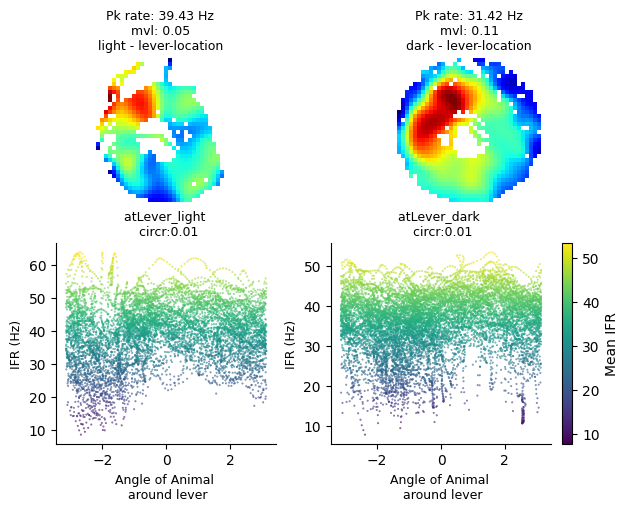

In [9]:

col = 6
row = 2
sizePerRow, sizePerCol = 2.5, 2.5
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


#### The Map of the cells 
session_cells = cells[(cells.session == sSes.name)]
conditions = ['all_light', 'all_dark']
rs = ['none']

celltoplot= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[0].cluId
gscell = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,:2], wspace=0.0)
plot_multiple_lever_maps(gscell, celltoplot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8)
ax= fig.add_subplot(gs[1,0])
interName= 'atLever_light'
ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes.name,ses,sSes,cells,
                                            interName= interName, ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType="none" )

ax.scatter(angles, ifr.mean(axis= 0), c=ifr.mean(axis= 0), cmap='viridis', alpha=0.75, s= 0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Angle of Animal \n  around lever ', fontsize=9)##
ax.set_ylabel('IFR (Hz)', fontsize=9)
circr= circcorrcoef(angles, ifr.mean(axis= 0)) 
ax.set_title(f'{interName} \n circr:{circr:.2f}', fontsize=9)


ax= fig.add_subplot(gs[1,1])
interName= 'atLever_dark'
ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes.name,ses,sSes,cells, interName= interName, ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType= 'none' )

ax.scatter(angles, ifr.mean(axis= 0), c=ifr.mean(axis= 0), cmap='viridis', alpha=0.75, s= 0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Angle of Animal \n  around lever ', fontsize=9)##
ax.set_ylabel('IFR (Hz)', fontsize=9)
circr= circcorrcoef(angles, ifr.mean(axis= 0)) 
ax.set_title(f'{interName} \n circr:{circr:.2f}', fontsize=9)
plt.colorbar(plt.cm.ScalarMappable( cmap='viridis', norm=plt.Normalize(np.min(ifr.mean(axis= 0)), np.max(ifr.mean(axis= 0)))), ax=ax, label='Mean IFR')



In [22]:
def run_evalute_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5): 
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
        
        ## get test and training dataset
        #train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses,
        #                                                    interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=False)
        
        train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses, cells,interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none")
        
        ### get my model 
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
        #print("Device available:", device)

        #optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
        optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss() # 
        model.train()


        ### train the model 
        df, best_model_state = training_loop(n_epochs=config["num_epochs"],
                     optimizer=optimizer,
                     model = model,
                     loss_fn = loss_fn,
                     train_data_loader=train_data_loader,
                     test_data_loader=test_data_loader, #changed to look at prediction in training dataset
                     config=config,
                     device = device,
                     verbose=False)
    
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

        myMetrics= {'session': sSes.name,
                   'df': df, 
                   'mse_test': mse_test, 
                   'outputs_test': outputs_test, 
                    'labels_test': labels_test, 
                    'mse_train': mse_train, 
                    'outputs_train': outputs_train,
                    'labels_train':labels_train,
                    'config': config
               }
        
    else:
        myMetrics=np.nan
    return myMetrics

def Plot_labes_outPuts_from_model(gs,  df,config, labels_test, labels_train, outputs_train, outputs_test, mse_train, mse_test ):
    

    ax= fig.add_subplot(gs[0,0])
    ax.plot(df.epochs, df.train_loss, label= 'Train.')
    ax.plot(df.epochs, df.test_loss, label= 'Test')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc= 'center')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.set_title('n_epochs:{} ' .format(config['num_epochs']), fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,1])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,0], outputs_train[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,0], outputs_train[:,0])
    circr= abs(circcorrcoef(labels_train[:,0], outputs_train[:,0])) 

    # plot the identity line
    ax.plot([min(labels_train[:,0]), max(labels_train[:,0])], [min(labels_train[:,0]), max(labels_train[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, SinAngle' .format(r,circr, mse_train[0]), fontsize=9)
    # Add legend
    plt.legend()


    ax= fig.add_subplot(gs[0,2])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,0], outputs_test[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r,p= pearsonr(labels_test[:,0], outputs_test[:,0])
    circr= abs(circcorrcoef(labels_test[:,0], outputs_test[:,0])) 

    # plot the identity line
    ax.plot([min(labels_test[:,0]), max(labels_test[:,0])], [min(labels_test[:,0]), max(labels_test[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, SinAngle' .format(r,circr, mse_test[0]), fontsize=9)
    # Add legend
    #ax.legend(loc='upper center', bbox_to_anchor=(1, 1.3), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,3])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,1], outputs_train[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,1], outputs_train[:,1]) ## labels are the Angles
    circr= circcorrcoef(labels_train[:,1], outputs_train[:,1]) ## outputs are the pred_angles
    # plot the identity line
    ax.plot([min(labels_train[:,1]), max(labels_train[:,1])], [min(labels_train[:,1]), max(labels_train[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, CosAngle' .format(r,circr, mse_train[1]), fontsize=9)
    # Add legend


    ax= fig.add_subplot(gs[0,4])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,1], outputs_test[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles ')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_test[:,1], outputs_test[:,1])
    circr= abs(circcorrcoef(labels_test[:,1], outputs_test[:,1])) 

    # plot the identity line
    ax.plot([min(labels_test[:,1]), max(labels_test[:,1])], [min(labels_test[:,1]), max(labels_test[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, CosAngle' .format(r,circr, mse_test[1]), fontsize=9)
    # Add legend

    ###########################
    #### plot the original angle vs predicted angle in test and training datasets: 
    #############################

    Angle_train = np.arctan2(labels_train[:,0], labels_train[:,1])
    Angle_train_pred = np.arctan2(outputs_train[:,0], outputs_train[:,1])


    Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
    Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])

    ################
    ##################
    ##
    ###############
    ##############
    ax= fig.add_subplot(gs[1,0])
    ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_train, Angle_train_pred)
    circr= abs(circcorrcoef(Angle_train, Angle_train_pred)) 

    ax.set_title('Train dataset \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)

    # plot the identity line
    ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')


    ax= fig.add_subplot(gs[1,1])
    ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_test, Angle_test_pred)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))

    ax.set_title('Test dataset \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')


    ## 
    ax= fig.add_subplot(gs[1,2])
    sns.histplot(Angle_train, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_train_pred, color='r', label='Predi. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Train', fontsize=9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1,3])
    sns.histplot(Angle_test, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_test_pred, color='r', label='Predic. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Test. from model', fontsize= 9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()

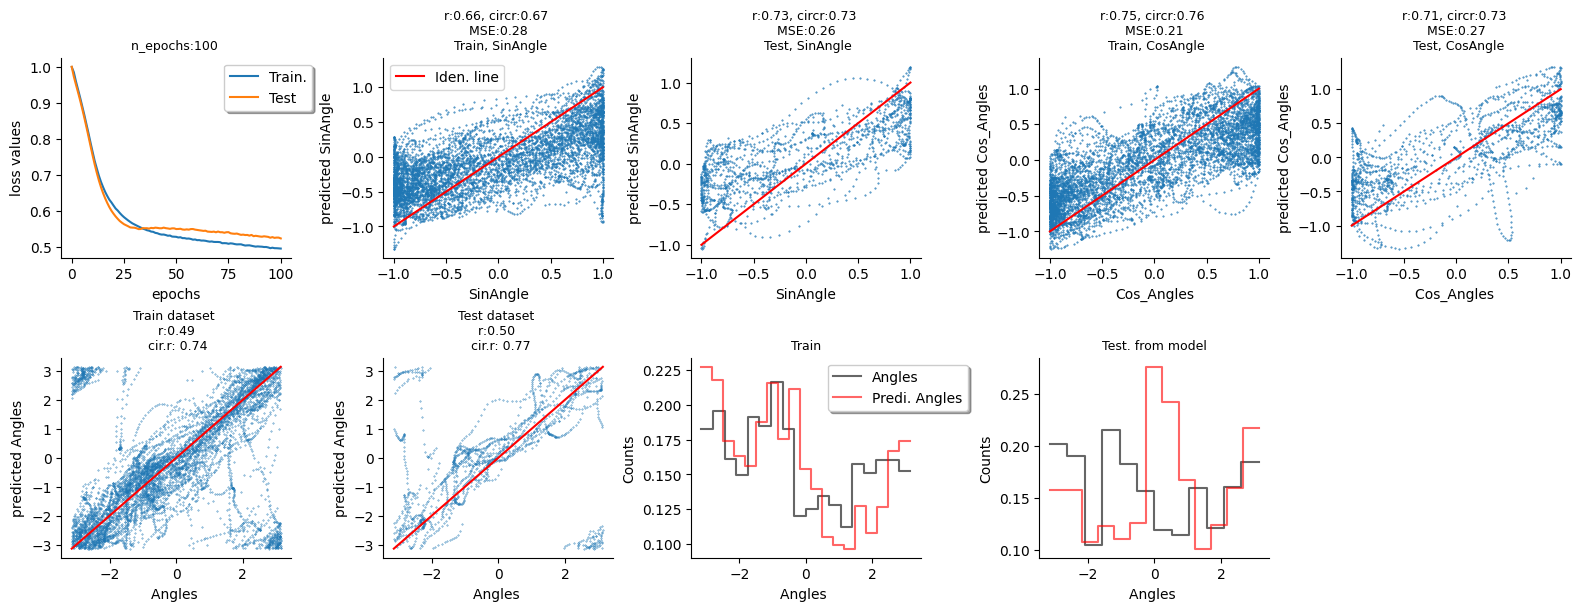

In [23]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'],myMetrics['config'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])
